In [ ]:
import os
import wave
import contextlib
from pathlib import Path
from google.colab import files
import cv2
from google.colab.patches import cv2_imshow



In [ ]:
#best case, the dataset is in drive/MyDrive/datasets/DISTANCE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#filter files that actually have sound by their size (not the best)
actualFiles = []
counter = 0
directory = r'drive/MyDrive/DEEPNN/distance1_23/'
for filename in os.listdir(directory):
  if(filename.endswith(".wav")):
    size = Path(directory + filename).stat().st_size
    if(size >= 59):
      actualFiles.append(directory + filename)
  counter += 1

In [ ]:
actualFiles

In [ ]:
#sanity check, should be 2500+
len(actualFiles)

2563

In [ ]:
pip install comet_ml


     |████████████████████████████████| 276kB 24.6MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 532kB 11.8MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp37-none-any.whl size=34547 sha256=6734da39753ad0fb3bffdd7b833324fab341300a9708533f1e768ea687c5d017
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


In [ ]:
from comet_ml import Experiment
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.io import wavfile as wav
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

In [ ]:
train = pd.read_csv("drive/MyDrive/DEEPNN/metadata_updated_version.csv")
train.head()

,fileName,distance,label
0,10000.wav,2,"Breathing,Respiratory_sounds"
1,100005.wav,2,"Rattle_(instrument),Percussion,Musical_instrum..."
2,10000.wav,2,"Breathing,Respiratory_sounds"
3,100005.wav,2,"Rattle_(instrument),Percussion,Musical_instrum..."
4,100007.wav,2,"Rattle_(instrument),Percussion,Musical_instrum..."


In [ ]:
len(train[train['distance']==2])

1521

In [ ]:
#notice that one file has multiple labels, we need to categorize them better

#all available labels in the dataset
labelDict = {}
#what label does each file have, ex.
#1000.wav is Wind
fileToLabel = {}
#what distance is each file
fileToDistance = {}
for elem in actualFiles:
  try:
    helper = elem.split("/")[-1]
    allLabels = train.loc[train['fileName'] == helper]['label'].values[0].split(",")
    distance = train.loc[train['fileName'] == helper]['distance'].values[0]
    fileToDistance[elem] = distance
    fileToLabel[elem] = allLabels
    for label in allLabels:
      if(label in labelDict):
        labelDict[label].append(helper)
      else:
        labelDict[label] = [helper]
  except:
    print(helper)
    print(train.loc[train['fileName'] == helper]['label'])
  

In [ ]:
fileToDistance

In [ ]:
#we want all files to have the same amount of labels
#find the maximum number of labels from all of the files. if some file has less than that, just copy some label until it has the requires amount
max_labels = len(max(fileToLabel.values()))
for key in fileToLabel:
  count = len(fileToLabel[key])
  if(count != max_labels):
    lastValue = fileToLabel[key][-1]
    for i in range(max_labels - count):
      fileToLabel[key].append(lastValue)

In [ ]:
#sanity check
len(min(fileToLabel.values()))


4

In [ ]:
len(labelDict)
len(fileToLabel)

2563

In [ ]:
labelCount = {}
for elem in labelDict:
  labelCount[elem] = len(labelDict[elem])
print(labelCount)

{'Wind_instrument_and_woodwind_instrument': 222, 'Musical_instrument': 766, 'Music': 766, 'Guitar': 128, 'Plucked_string_instrument': 133, 'Bark': 13, 'Dog': 56, 'Domestic_animals_and_pets': 68, 'Animal': 250, 'Laughter': 37, 'Human_voice': 248, 'Water': 68, 'Insect': 27, 'Wild_animals': 132, 'Fireworks': 33, 'Explosion': 80, 'Bathtub_(filling_or_washing)': 12, 'Water_tap_and_faucet': 25, 'Domestic_sounds_and_home_sounds': 198, 'Sink_(filling_or_washing)': 28, 'Toilet_flush': 15, 'Drawer_open_or_close': 15, 'Keys_jangling': 7, 'Hiss': 8, 'Clock': 17, 'Mechanisms': 64, 'Tearing': 28, 'Sawing': 8, 'Tools': 33, 'Engine_starting': 10, 'Engine': 57, 'Cupboard_open_or_close': 1, 'Camera': 23, 'Slam': 15, 'Door': 41, 'Packing_tape_and_duct_tape': 4, 'Splash_and_splatter': 6, 'Liquid': 48, 'Walk_and_footsteps': 12, 'Glass': 29, 'Zipper_(clothing)': 11, 'Drip': 18, 'Fill_(with_liquid)': 7, 'Skateboard': 22, 'Vehicle': 343, 'Bird': 100, 'Meow': 5, 'Cat': 12, 'Squeak': 37, 'Cough': 8, 'Respirator

In [ ]:
#https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc
files = dict()
for label in labelDict:
  path = directory + labelDict[label][-1]
  files[label] = path
print(files)

{'Wind_instrument_and_woodwind_instrument': 'drive/MyDrive/DEEPNN/distance1_23/100476.wav', 'Musical_instrument': 'drive/MyDrive/DEEPNN/distance1_23/109558.wav', 'Music': 'drive/MyDrive/DEEPNN/distance1_23/109558.wav', 'Guitar': 'drive/MyDrive/DEEPNN/distance1_23/109553.wav', 'Plucked_string_instrument': 'drive/MyDrive/DEEPNN/distance1_23/109553.wav', 'Bark': 'drive/MyDrive/DEEPNN/distance1_23/108631.wav', 'Dog': 'drive/MyDrive/DEEPNN/distance1_23/108631.wav', 'Domestic_animals_and_pets': 'drive/MyDrive/DEEPNN/distance1_23/108843.wav', 'Animal': 'drive/MyDrive/DEEPNN/distance1_23/109605.wav', 'Laughter': 'drive/MyDrive/DEEPNN/distance1_23/109625.wav', 'Human_voice': 'drive/MyDrive/DEEPNN/distance1_23/109653.wav', 'Water': 'drive/MyDrive/DEEPNN/distance1_23/109719.wav', 'Insect': 'drive/MyDrive/DEEPNN/distance1_23/109083.wav', 'Wild_animals': 'drive/MyDrive/DEEPNN/distance1_23/109605.wav', 'Fireworks': 'drive/MyDrive/DEEPNN/distance1_23/109740.wav', 'Explosion': 'drive/MyDrive/DEEPNN/di

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key API_KEY is invalid, please check it against the dashboard. Your experiment would not be logged 
For more details, please refer to: https://www.comet.ml/docs/python-sdk/warnings-errors/


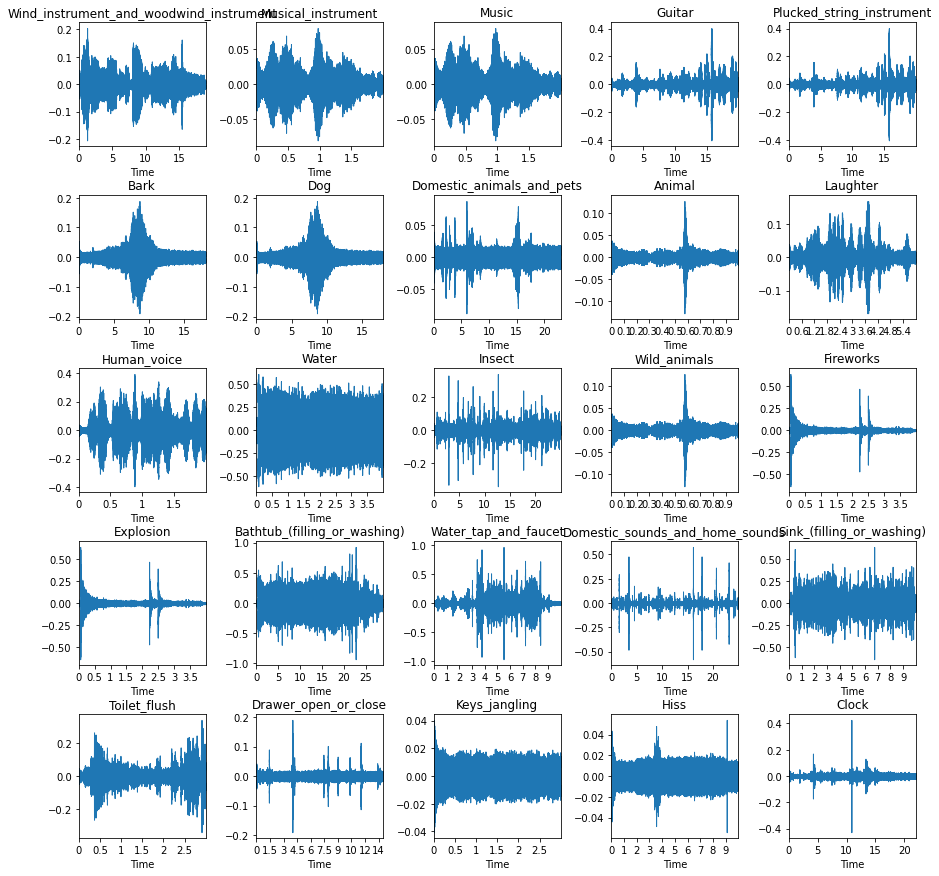

In [ ]:
experiment = Experiment(api_key="API_KEY",
                        project_name="AudioDistance")
fig = plt.figure(figsize=(15,15))# Log graphic of waveforms to Comet
experiment.log_image('class_examples.png')
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labelDict.keys()):
  if(i == 25):
    break
  fn = files[label]
  fig.add_subplot(5, 5, i+1)
  plt.title(label)
  data, sample_rate = librosa.load(fn)
  librosa.display.waveplot(data, sr= sample_rate)
plt.savefig('class_examples.png')

In [ ]:
# Log graphic of waveforms to Comet
experiment.log_image('class_examples.png')

In [ ]:
fn = directory + '1125.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 44100
Librosa sample rate: 22050


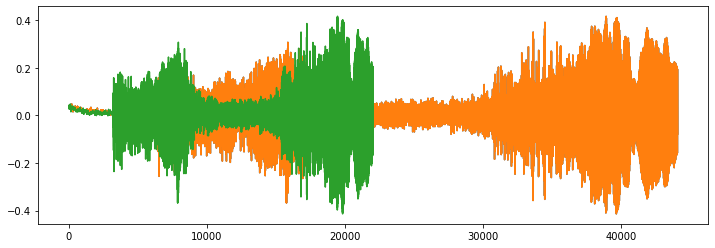

In [ ]:
plt.figure(figsize=(12, 4))
#orange
plt.plot(scipy_audio)
#green, i think?
plt.plot(librosa_audio)
plt.savefig('original_audio.png')
experiment.log_image('original_audio.png')

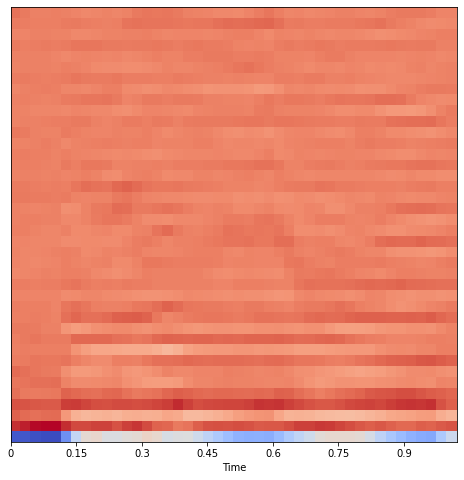

In [ ]:
#explain?
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')
experiment.log_image('MFCCs.png')

In [ ]:
#return mfcc
def extract_features(file_name):
  audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
  #binaural sound method of normalization
  rms = np.sqrt(1/len(audio) * np.sum(audio**2))
  audio_normed = audio/rms
  mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_processed = np.mean(mfccs.T,axis=0)
  return mfccs_processed

In [ ]:
features = []
#for testing, put like 150 (the first 50 have the same labels)
counter = 0
# Iterate through each sound file and extract the features 
for fname in actualFiles:
  if(counter == 150):
    break
  data = extract_features(fname)
  features.append([data, fileToLabel[fname]])
  counter += 1
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [ ]:
featuresdf.head()

,feature,class_label
0,"[-269.5469, 29.049139, -21.342485, 37.363823, ...","[Wind_instrument_and_woodwind_instrument, Musi..."
1,"[-233.00648, 54.78295, -0.8521155, 60.740578, ...","[Wind_instrument_and_woodwind_instrument, Musi..."
2,"[-217.95532, 59.33897, -7.643774, 51.7567, -25...","[Wind_instrument_and_woodwind_instrument, Musi..."
3,"[-323.4843, 78.47965, 26.19906, 46.593052, -12...","[Wind_instrument_and_woodwind_instrument, Musi..."
4,"[-272.4493, 77.24428, 7.3753734, 57.673805, -1...","[Wind_instrument_and_woodwind_instrument, Musi..."


#DISTANCE TESTING

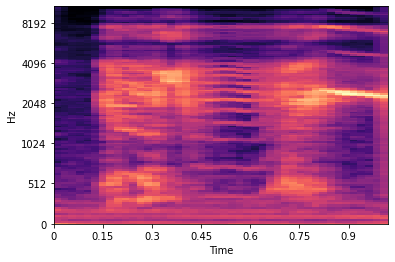

In [ ]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6982911/
#distance 2
y, sr = librosa.load(directory + '1125.wav',duration=3)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps_db= librosa.power_to_db(ps, ref=np.max)

librosa.display.specshow(ps_db, x_axis='time', y_axis='mel')

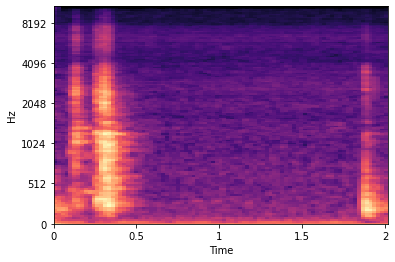

In [ ]:
#distance 1
y, sr = librosa.load(directory + '121759.wav',duration=3)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps_db= librosa.power_to_db(ps, ref=np.max)

librosa.display.specshow(ps_db, x_axis='time', y_axis='mel')


In [ ]:
#Using a CRNN architecture to enable the model to learn both the spectral and temporal feeatures and relationships
#model itself is three 2D conv layers, which extract features from the input log-scaled mel spectograms
#the leakyrely activation function is applied to the output of each convolution layer and max-pooled to reduce their dimensoions
#can't be bothered to write the rest, look at the pic in the paper

In [ ]:
#model is
import numpy as np
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Dense, LSTM, add, concatenate, Dropout, Lambda, Flatten, GRU, LeakyReLU
from keras.models import Model
import keras.backend as K

def ctc_lambda_func(args):
  iy_pred, ilabels, iinput_length, ilabel_length = args
  # the 2 is critical here since the first couple outputs of the RNN
  # tend to be garbage:
  iy_pred = iy_pred[:, 2:, :]  # no such influence
  return K.ctc_batch_cost(ilabels, iy_pred, iinput_length, ilabel_length)

#https://github.com/kurapan/CRNN/blob/master/models.py
def build_distance_model():

  inputs = Input((64,64,3))
  c1=Conv2D(32, (3,3), padding = 'same',)(inputs)
  a1=Activation('LeakyReLU')(c1)
  c2=Conv2D(64, (3,3))(a1)
  a2=Activation('LeakyReLU')(c2)
  c3=Conv2D(64, (3,3))(a2)
  a3=Activation('LeakyReLU')(c3)
  p1=MaxPooling2D(pool_size=(2, 2))(a3)

  c4=Conv2D(64, (3,3))(p1)
  a4=Activation('LeakyReLU')(c4)
  c5=Conv2D(64, (3,3))(a4)
  a5=Activation('LeakyReLU')(c5)
  c6=Conv2D(64, (3,3))(a5)
  a6=Activation('LeakyReLU')(c6)
  p2=MaxPooling2D(pool_size=(2, 2))(a6)

  c7=Conv2D(128, (3,3))(p2)
  a7=Activation('LeakyReLU')(c7)
  c8=Conv2D(128, (3,3))(a7)
  a8=Activation('LeakyReLU')(c8)
  c9=Conv2D(128, (3,3))(a8)
  a9=Activation('LeakyReLU')(c9)
  p3=MaxPooling2D(pool_size=(2, 2))(a9)
  d1=Dropout(0.25)(p3)
  #model.add(Flatten())
  d1_shape=d1.get_shape()

  reshape = Reshape(target_shape=(int(d1_shape[1]), int(d1_shape[2] * d1_shape[3])), name='reshape')(d1)

  dense= Dense(512, activation='relu')(reshape)

  l1= LSTM(512, return_sequences=True)(dense)
  l1back = LSTM(512, go_backwards=True, return_sequences=True)(l1)
  lstm_add = add([l1, l1back])
  #dense2=Dense(1,activation='softmax')(lstm_add)

  lstm_11 = LSTM(512,  return_sequences=True)(lstm_add)
  lstm_11_back = LSTM(512, go_backwards=True, return_sequences=True)(lstm_11)
  lstm_11_concat = concatenate([lstm_11, lstm_11_back])
  do_11 = Dropout(0.5)(lstm_11_concat)

  fc_12 = Dense(1, activation='sigmoid')(do_11)
  
  prediction_model = Model(inputs=inputs, outputs=fc_12)


 # prediction_model = Model(inputs=inputs, outputs=dense2)
  return prediction_model
  
  #need to fix this
  #model.add(Reshape(target_shape = (3,3,128))))

  #after fixing above, enable this
  #model.add(LSTM(128))
  #model.add(Activation('softmax'))
  #model.add(LSTM(128))
  #model.add(Activation('softmax'))
  de1=Dense(1)(d1)
  a10=Activation('softmax')(de1)
  """
  #I just don't know what this is supposed to be

  inputs = Input(shape = (128,128,1,))
  c_1 = Conv2D(32, (3, 3), input_shape = (128,128), padding='same', name='conv_1')(inputs)
  x = LeakyReLU()(c_1)
  c_2 = Conv2D(32, (3, 3), padding='same', name='conv_2')(c_1)
  x = LeakyReLU()(c_2)
  c_3 = Conv2D(32, (3, 3), padding='same', name='conv_3')(c_2)
  x = LeakyReLU()(c_3)
  #is this needed?
  #bn_3 = BatchNormalization(name='bn_3')(c_3)
  p_3 = MaxPooling2D(pool_size=(2, 2), name='maxpool_3')(x)
  print(1)

  c_4 = Conv2D(64, (3, 3), padding='same', name='conv_4')(p_3)
  x = LeakyReLU()(c_4)
  c_5 = Conv2D(64, (3, 3), padding='same', name='conv_5')(c_4)
  x = LeakyReLU()(c_5)
  #bn_5 = BatchNormalization(name='bn_5')(c_5)
  p_5 = MaxPooling2D(pool_size=(2, 2), name='maxpool_5')(x)
  print(2)
  

  c_6 = Conv2D(128, (3, 3), padding='same', name='conv_6')(p_5)
  x = LeakyReLU()(c_6)
  c_7 = Conv2D(128, (3, 3), padding='same', name='conv_7')(c_6)
  x = LeakyReLU()(c_7)
  #bn_7 = BatchNormalization(name='bn_7')(c_7)
  p_7 = MaxPooling2D(pool_size=(2, 2), name='maxpool_6')(x)
  p_7_shape = p_7.get_shape()
  print(3)

  #why is this like this, i don't know, but we shouldn't multiple by 2 randomly, makes no sense
  reshape = Reshape(target_shape=(int(p_7_shape[1]), int(p_7_shape[2] * p_7_shape[3])), name='reshape')(p_7)
  print(4)
  fc_9 = Dense(128, kernel_initializer='he_normal', activation='softmax', name='fc_9')(reshape)
  print("Dense")
  #maybe 128 is wrong, we will see
  lstm_10 = LSTM(128, kernel_initializer="he_normal", return_sequences=True, name='lstm_10')(fc_9)
  lstm_10_back = LSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True, name='lstm_10_back')(fc_9)
  lstm_10_add = add([lstm_10, lstm_10_back])
  print(5)


  lstm_11 = LSTM(128, kernel_initializer="he_normal", return_sequences=True, name='lstm_11')(lstm_10_add)
  lstm_11_back = LSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True, name='lstm_11_back')(lstm_10_add)
  lstm_11_concat = concatenate([lstm_11, lstm_11_back])
  do_11 = Dropout(0.25, name='dropout')(lstm_11_concat)
  print(6)

  fc_12 = Dense(1, kernel_initializer='he_normal', activation='softmax', name='fc_12')(do_11)
  print(7)
  prediction_model = Model(inputs=inputs, outputs=fc_12)

  #need to figure out label length, but if it's distance, should be 1
  labels = Input(name='labels', shape=1, dtype='float32')
  input_length = Input(name='input_length', shape=[1], dtype='int64')
  label_length = Input(name='label_length', shape=[1], dtype='int64')
  

  ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([fc_12, labels, input_length, label_length])
    
  training_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=[ctc_loss])     

  return training_model, prediction_model
  """
  return model

In [ ]:
#https://medium.com/gradientcrescent/urban-sound-classification-using-convolutional-neural-networks-with-keras-theory-and-486e92785df4
#this is the only thing that makes sense to me
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    #create the dictionaries if you don't have them
    #if you aren't sure about about the path, right click on the created folder and click show path
    #it is clipboarded, paste is somewhere and see the path
    filename  = 'drive/MyDrive/working/train/' + name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    #del filename,name,clip,sample_rate,fig,ax,S

In [ ]:
def create_spectrogram_test(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    #create the dictionaries if you don't have them
    filename  =  'drive/MyDrive/working/test/' + name + '.jpg'
    fig.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
   #del filename,name,clip,sample_rate,fig,ax,S

In [ ]:
!rm -rf /drive/MyDrive/working/train/
!rm -rf /drive/MyDrive/working/test/

!mkdir /drive/MyDrive/working/train/
!mkdir /drive/MyDrive/working/test/

mkdir: cannot create directory ‘/drive/MyDrive/working/train/’: No such file or directory
mkdir: cannot create directory ‘/drive/MyDrive/working/test/’: No such file or directory


In [ ]:
import random
random.shuffle(actualFiles)
train_files =actualFiles[:int(len(actualFiles)*0.8)]
test_files =actualFiles[int(len(actualFiles)*0.8):]

for file in train_files:
  filename,name = file, file.split('/')[-1].split('.')[0]
  create_spectrogram(filename,name)

In [ ]:
for file in test_files:
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram_test(filename,name)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

def append_ext(fn):
    return fn+".jpg"

In [ ]:
img_width, img_height = 64,64
batch_size = 20
epochs = 1

fuckThistrain = []
fuckThistrain2=[]

for elem in train_files:
  fuckThistrain.append(elem.split("/")[-1])

traindf = train[train['fileName'].isin(fuckThistrain)]
traindf.drop_duplicates(inplace=True)

for index, row in traindf.iterrows():
      traindf.at[index, 'fileName'] = row['fileName'].split(".")[0] + ".jpg"
      fuckThistrain2.append(row['fileName'].split(".")[0] + ".jpg")
    
    

traindf.drop("label",inplace=True,axis=1)
nb_train_samples = len(traindf) # number of train samples
#fuckThistrain2=list(set(fuckThistrain2)) #somehow it is duplicated at above
def train_generator():
    while True:
        for start in range(0, nb_train_samples, batch_size):
            x_batch = []
            y_batch = []

        

           
            end = min(start + batch_size, nb_train_samples)
            for img_path in range(start, end):
                img = cv2.imread(r'drive/MyDrive/working/train/'+fuckThistrain2[img_path])
                img = cv2.resize(img, (img_width, img_height),interpolation=cv2.INTER_AREA)
                x_batch.append(img)
                if fuckThistrain2[img_path] in list(traindf.fileName.values):
                    y_batch.append([int(traindf[traindf['fileName']==fuckThistrain2[img_path]]['distance'])])
                elif fuckThis2[img_path] in list(traindf.fileName.values):
                    y_batch.append([int(traindf[traindf['fileName']==fuckThistrain2[img_path]]['distance'])])
            
            yield (np.array(x_batch), np.array(y_batch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fuckThis = []
fuckThis2=[]
for elem in test_files:
  fuckThis.append(elem.split("/")[-1])

testdf = train[train['fileName'].isin(fuckThis)]
testdf.drop_duplicates(inplace=True)

for index, row in testdf.iterrows():
    testdf.at[index, 'fileName'] = row['fileName'].split(".")[0] + ".jpg"
    fuckThis2.append(row['fileName'].split(".")[0] + ".jpg")

testdf.drop("label",inplace=True,axis=1)

nb_test_samples=len(testdf) #number of test samples
def test_generator():
    while True:
        for start in range(0, nb_test_samples, batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + batch_size, nb_test_samples)
            for img_path in range(start, end):
                img = cv2.imread(r'drive/MyDrive/working/test/'+fuckThis2[img_path])
                img = cv2.resize(img, (img_width, img_height),interpolation=cv2.INTER_AREA)
                x_batch.append(img)
                if fuckThis2[img_path] in list(testdf.fileName.values):
                    y_batch.append([int(testdf[testdf['fileName']==fuckThis2[img_path]]['distance'])])
                elif fuckThis2[img_path] in list(traindf.fileName.values):
                    y_batch.append([int(testdf[testdf['fileName']==fuckThis2[img_path]]['distance'])])
            
            yield (np.array(x_batch), np.array(y_batch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#needs to be changed still
from keras import regularizers, optimizers
model = build_distance_model()
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),loss="binary_crossentropy",metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:

model.fit_generator(
    train_generator(),
    epochs= epochs,
    steps_per_epoch= nb_train_samples // batch_size,
    validation_data= test_generator(),
    validation_steps = nb_test_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



50/50 [==============================] - 62s 1s/step - loss: -7.3654 - accuracy: 0.5170 - val_loss: -7.1671 - val_accuracy: 0.5300
